## Deep Learning with Keras <br>
In this notebook, we're going to experiment with Deep Neural Networks for image recognition using simple linear classifiers and convolutional neural networks. We will be using the Keras library. The purpose of this network is to provide a high level introduction into computer vision and the different components of what it takes to produce high accuracy outputs using Deep Learning.

In [488]:
# Some imports 
# import matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline
# import numpy for tensor manipulation
import numpy as np
import math
# import keras and dependencies
import keras
from keras import Sequential, optimizers
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, UpSampling2D, BatchNormalization
from keras.utils import np_utils
# some IPython magic
from IPython.display import display, Math, Latex, Image
from IPython.core.display import HTML

# some helper functions to make our life easier

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(72,72), cmap='gray')

im = generate_a_disk(10)
#plt.imshow(im.reshape(72,72), cmap='gray')

[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(72,72), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]



### Simple Classification
In this example, we're going to attempt to create a simple linear classifier using a one layer deep neural network while using the stochastic gradient descent optimizer as well as the Adam optimizer. 
* __Stochastic Gradient Descent:__ <br>
Stochastic Gradient Descent is one of the most well known weight optimization techniques in machine learning today. Gradient Descents updates the weights of Neural Networks by minimizing the error incurred by the prediction model. Stochastic Gradient Descent is a variation of Gradient Descent that minimizes the error for each example in the training set.  
In general, for any objective function $J(\theta)$, we want to optimize $\theta$ such that <br> 

$$ \theta = \theta - \alpha \triangledown \theta E[J(\theta)] $$

Where $\alpha$ is the learning rate of the optimizer, think of Gradient Descent as the fastest way to the bottom of a hill, and the learning rate being the size of one's step to get there - however there is a danger in setting the learning rate either too small or big, if it's too small it may not converge towards the bottom, if it's too big it may end up overstepping the bottom.

<img src="http://blog.datumbox.com/wp-content/uploads/2013/10/gradient-descent.png"> <br>

* __Adam Optimizer:__
Adam is one of the leading optimization techniques currenty being implemented in Deep Learning. It's name is derived from adaptive moment estimation. Machine learning optimizers have made strides in development from gradient descent, to stochastic gradient descent to more adaptive optimzers that utilize a specific learning rate for each gradient in the optimization process. A much more detailed overview of optimzers can be found [here](http://ruder.io/optimizing-gradient-descent/index.html#adam) - a less detailed but fun and casual history lesson can be found [here](https://www.youtube.com/watch?v=nhqo0u1a6fw).
Essentially, Adam stores approximates the adaptive first moment $m_t$ (mean) and second moment $v_t$ (variance) of the gradients by storing an exponentially decaying average of past gradients and past squared gradients - using the following: 
<br>
$$m_{t+1} = \beta_1m_t - (1 - \beta_1)g_t$$
$$v_{t+1} = \beta_2v_t - (1 - \beta_2)g_t^2$$ <br>
In general, the Adam optimzer optimzes the hyperparameters of an objective function $J(\theta)$ by substracting the variance adjusted exponentially decaying average gradient from the current estimation of $\theta$ using the following: <br>
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{v_t} + \epsilon}m_{t}$$ <br>
Now, let us begin!

In [3]:
%%capture
# generate a training dataset of random disks, rectangles, triangles
[X_train, Y_train] = generate_dataset_classification(300,20)
# transform labels into categorical matrix - necessary for keras
Y_train = keras.utils.to_categorical(Y_train, 3)

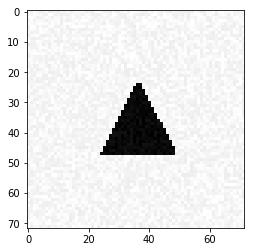

In [4]:
# visualize the first training sample
plt.imshow(X_train[0].reshape(72,72), cmap='gray')

In [5]:
# create number of columns
n_cols = X_train.shape[1]
# build the model
# build the first layer of the model
model = Sequential()
# add a dense fully connected hidden layer with 32 nodes - using the relu activation function
model.add(Dense(32, activation = 'relu', input_shape = (n_cols,)))
# add the output layer with 3 nodes - one for each class - using softmax activation for classification
model.add(Dense(3, activation = 'softmax'))
# compile the model
# create a stochastic gradient descent optimizer, with 0.01 learning rate
sgd = optimizers.SGD(lr = 0.01, clipnorm = 1.)
# compile model with loss function being categorical crossentropy for classification
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [6]:
# fit model
# define early stopping where model stops running after 5 epochs of non improvement
early_stopping_monitor = EarlyStopping(patience = 5)
# fit model with 0.3 validation split over 100 epochs and batch size of 32
model.fit(X_train, Y_train, validation_split = 0.3, epochs = 100, batch_size = 32, callbacks = [early_stopping_monitor])

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 0s 654us/step - loss: 1.2743 - acc: 0.2762 - val_loss: 1.1172 - val_acc: 0.3000
Epoch 2/100
210/210 [==============================] - 0s 216us/step - loss: 1.0621 - acc: 0.4000 - val_loss: 0.9301 - val_acc: 0.6111
Epoch 3/100
210/210 [==============================] - 0s 246us/step - loss: 0.9544 - acc: 0.5333 - val_loss: 0.8656 - val_acc: 0.6667
Epoch 4/100
210/210 [==============================] - 0s 268us/step - loss: 0.8705 - acc: 0.6286 - val_loss: 0.8172 - val_acc: 0.6333
Epoch 5/100
210/210 [==============================] - 0s 230us/step - loss: 0.8103 - acc: 0.7143 - val_loss: 0.7374 - val_acc: 0.8000
Epoch 6/100
210/210 [==============================] - 0s 320us/step - loss: 0.7631 - acc: 0.6810 - val_loss: 0.6888 - val_acc: 0.7444
Epoch 7/100
210/210 [==============================] - 0s 251us/step - loss: 0.7320 - acc: 0.6762 - val_loss: 0.6730 - val_acc: 0.6778
Epoch 8/10

In [7]:
# generate one test sample
X_test = generate_a_rectangle()
# adjust shape so it has same shape as training data
X_test = X_test.reshape(1, X_test.shape[0])
# predict whether our model predicts correctly, if output is 0 then we are good!
model.predict_classes(X_test)

array([0])

In [8]:
# Now let's recompile our model using Adam
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(X_train, Y_train, validation_split = 0.3, epochs = 100, batch_size = 32, callbacks = [early_stopping_monitor])

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 0s 635us/step - loss: 2.0482 - acc: 0.6571 - val_loss: 0.7185 - val_acc: 0.6667
Epoch 2/100
210/210 [==============================] - 0s 207us/step - loss: 0.6726 - acc: 0.7810 - val_loss: 0.6049 - val_acc: 0.9444
Epoch 3/100
210/210 [==============================] - 0s 268us/step - loss: 0.6030 - acc: 0.8571 - val_loss: 0.5354 - val_acc: 0.9444
Epoch 4/100
210/210 [==============================] - 0s 262us/step - loss: 0.5450 - acc: 0.8714 - val_loss: 0.4711 - val_acc: 0.8667
Epoch 5/100
210/210 [==============================] - 0s 277us/step - loss: 0.4759 - acc: 0.9286 - val_loss: 0.4269 - val_acc: 0.9111
Epoch 6/100
210/210 [==============================] - 0s 282us/step - loss: 0.4444 - acc: 0.9048 - val_loss: 0.4065 - val_acc: 0.9778
Epoch 7/100
210/210 [==============================] - 0s 329us/step - loss: 0.4260 - acc: 0.9048 - val_loss: 0.5121 - val_acc: 0.8000
Epoch 8/10

In [9]:
# now let's try predicting again
model.predict_classes(X_test)

array([0])

It seems Adam has much lower accuracy - and takes more iterations to converge for this specific use case.

### Visualization of the Weights
Now we can extract the weights of the model using the .get_weights method - and we can create a weight matrix by doing the dot product of the weights at each layer - let's visualize the output of the weights.

In [22]:
# get weights matrix
weights = model.get_weights()
weights_matrix = np.dot(weights[0], weights[2])

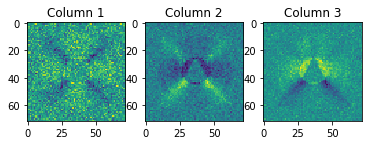

In [493]:
# visualize 3 columns of the weights matrix
plt.figure()
# first column
plt.subplot(131)
plt.title("Column 1")
plt.imshow(weights_matrix[:,0].reshape(72,72))
# second column
plt.subplot(132)
plt.imshow(weights_matrix[:,1].reshape(72,72))
plt.title("Column 2")
# third column
plt.subplot(133)
plt.imshow(weights_matrix[:,2].reshape(72,72))
plt.title("Column 3")

plt.show()

We can see that the first column has weights lit up with the shape of a rectangle, second is one of a circle, third is one of a triangle.

### A More Difficult Classification Problem
Now let's try to generate data for which the position of the shapes are changing constantly - this adds a layer of complexity to the problem since the linear classifier we created earlier is good capturing global features in our dataset however is not as robust when it comes to capturing local features in our images. This means that the position of our images is an important factor to take into consideration - a good alternative is the usage of convolutional neural networks.

In [93]:
%%capture
# create a thousand random shapes who's position changes constantly 
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
# transform labels into categorical matrix - necessary for keras
Y_train = keras.utils.to_categorical(Y_train, 3)

### Convolutional Neural Networks

  
Bilogically inspired models by research done on the visual cortex of mammals. Mammals perceive the world using a layered architecture of neurons in the brain.
Think of this model of the visual cortex as groups of neurons designed specifically to recognize different shapes. Each group of neurons fires at the sight of an object, and communicate with eachother to develop a holistic understanding of the perceived object.
  
  ![image](https://camo.githubusercontent.com/64678a23d60230cab2c9899990d54b00ffd0f41f/68747470733a2f2f7170682e65632e71756f726163646e2e6e65742f6d61696e2d71696d672d32333561636236306134383134323365616637306333396231376263393134622e77656270)<br>
  
  The system can be explained as hierarchical clusters of neurones that detect low level features and communicate between eachother in that hierarchy to develop a high level detection of objects. 
  Think of the hierarchy as the following:  
  * First cluster as a structure that recognizes low level features *i.e. contour of a face*
  * The second cluster as a structure that recognizes colors and shapes *skin color or jaw lines*
  * The third as a structure that recognizes detail *ears, nose and eyes *... continuing along this hierarchy*
  * Final cluster recognizes the entire object holistically *the face and the person attached to the face* 
  
  In summary - clusters are connected to each other and they represent some set of features. 
  Yann LeCun drew inspiration from this hierarchical model of the visual cortex to develop Convolutional Neural Networks - most notably:
  
  1) Local Connections: Each layer *(or cluster)* share a connection where they transfer learned features from one cluster to another<br>
  2) Layering: There is an obvious hierarchy between the different layers *(or clusters)* - which is analaguous to saying there's a hierarchy in learning *(from low level features to high level features)* <br>
  3) Spatial Invariance: Shifts in the inputs results in an equally shifted output - regardless of how we change an input image - the model should adapt and shift it's outputs accordingly. *(Humans have an ability to recognize an object even if it's upside down or shifted in a variety of conditions)* <br><br>

Thus the convolutional neural network architecture corresponds to something like this <br>
<img src="https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-9-15-21-pm.png?w=1024"> <br>
* Where an input data in the form of a 4D tensor *(number of samples, height of each sample, width of each sample, number of channels)* - it is important to note that the number of channels here refers to the color specification of each image - a colored image corresponds to Red (R), Green (G) and Blue (B) pixels (RGB image), so each image has 3 channels *(think of this as a three 2-dimensional matrices supperposed on top of eachother each corresponding to the intensity of the RGB pixels)*, whereas a gray image has only 1 channel. In our example we will be using a grey image only. <br><br>
* Our input data will be connected to a hidden convolution layer which applies a number of abritrary filters of an arbitrary dimension *(typically 3x3 or 5x5)* over our image. Think of a filter as a small flashlight of dimension 3x3 *(or 5x5)* that tries to understand our input images and draw a feature map. From the feature map the algorithm can understand local features in our data *(think an eye of a cat)* regardless of its position *(translation invariance)*. We can see the convolution operation greatly displayed here: <br><br>

  
  
<img src="https://ujwlkarn.files.wordpress.com/2016/08/giphy.gif?w=480&zoom=2">

<br><br>

* Where pooling is a subsampling operation that reduces the dimensionality of the extracted feature maps by applying a window of an arbitrary size *(this is called stride)* and extracts either the sum of the windows, max or average depending on the specification of the user. In this case we will be using maxpooling, which for each 2x2 window in the feature map we extract the highest values. This technique helps us reduce dimensionality while preserving information. We can take a look at this operation below: <br><br>

<img src="https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-10-at-3-38-39-am.png?w=500">
<br><br>
* Finally a traditional fully connected layer which produced a softmax output takes in the learned representations of the convolutional and maxpooling layers and outputs a prediction. For more information on convolutional neural networks and a much better breakdown, please refer to [this blogpost](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/).

In [100]:
# reshape each image in X_train so it fits convnet input shape
X_train = X_train.reshape(1000,72,72,1)

In [101]:
# create convnet model
conv_model = Sequential()
# add convolutional layer with 16 5x5 filters using relu activation
conv_model.add(Conv2D(16, (5,5), activation = 'relu', input_shape = (72,72,1)))
# add maxpooling layer
conv_model.add(MaxPooling2D((2,2)))
# add convolutional layer with 16 5x5 filters using relu activation
conv_model.add(Conv2D(16, (5,5), activation = 'relu'))
# add maxpooling layer
conv_model.add(MaxPooling2D((2,2)))
# add convolutional layer with 16 5x5 filters using relu activation
conv_model.add(Conv2D(16, (5,5), activation = 'relu'))
# add maxpooling layer
conv_model.add(MaxPooling2D((2,2)))
# add flatten layer to reduce output shape 
conv_model.add(Flatten())
# add output layer
conv_model.add(Dense(3, activation = 'sigmoid'))

In [102]:
# print summary of convnet model
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 16)        6416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
__________

In [103]:
# compile the model
conv_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy')

In [104]:
# fit model
conv_model.fit(X_train, Y_train, validation_split = 0.3, epochs = 100, batch_size = 32)

Train on 700 samples, validate on 300 samples
Epoch 1/100
700/700 [==============================] - 5s 6ms/step - loss: 1.0923 - val_loss: 1.0828
Epoch 2/100
700/700 [==============================] - 4s 5ms/step - loss: 1.0589 - val_loss: 1.0188
Epoch 3/100
700/700 [==============================] - 4s 5ms/step - loss: 0.9822 - val_loss: 0.9192
Epoch 4/100
700/700 [==============================] - 4s 5ms/step - loss: 0.8403 - val_loss: 0.8192
Epoch 5/100
700/700 [==============================] - 4s 5ms/step - loss: 0.7133 - val_loss: 0.5472
Epoch 6/100
700/700 [==============================] - 4s 5ms/step - loss: 0.5008 - val_loss: 0.4385
Epoch 7/100
700/700 [==============================] - 4s 5ms/step - loss: 0.3637 - val_loss: 0.4268
Epoch 8/100
700/700 [==============================] - 3s 4ms/step - loss: 0.2987 - val_loss: 0.2555
Epoch 9/100
700/700 [==============================] - 3s 5ms/step - loss: 0.2007 - val_loss: 0.2288
Epoch 10/100
700/700 [=======================

In [105]:
# reshape test same as train
X_test = X_test.reshape(300,72,72,1)
# produce predictions
predictions = conv_model.predict_classes(X_test)

In [106]:
#prediction accuracy
print("Accuracy score is {} %".format(accuracy_score(Y_test, predictions) * 100))

Accuracy score is 97.33333333333334 %


### A Regression Problem

Now let us try to predict the coordinates of the vertices of a triangle and it's shape - thus, we will create triangles with their respective coordinates of vertices. Before proceeding to modeling, we need to "normalize" our data by creating the centroids of each triangle by dividing with the each vertices' coordinates by 3. And then calculate the distance of each vertice to the centroid. 

In [24]:
%%capture
# create training set and labels
[X_train, Y_train] = generate_dataset_regression(1000, 20)
X_train = X_train.reshape(1000,72,72,1)

In [48]:
# separate vertices into set of 3 tuples for each vertices coordinates
vertices = [(Y_train[j][i],Y_train[j][i+1]) for j in range(0,1000) for i in range(0,len(Y_train[j]),2)]
vertices = [vertices[x:x+3] for x in range(0, len(vertices),3)]

In [194]:
# extract x coordinates for each vertices and calculate their mean to compute the centroid of each triangle
X_coordinates = [vertices[i][j][0] for i in range(0,len(vertices)) for j in range(0, len(vertices[i]))]
centroids_x = np.array([X_coordinates[x:x+3] for x in range(0, len(X_coordinates),3)])
centroid_x = [np.mean(centroids_x[i]) for i in range(0, 1000)]

In [198]:
# repeat the same process for y coordinates
Y_coordinates = [vertices[i][j][1] for i in range(0,len(vertices)) for j in range(0, len(vertices[i]))]
centroids_y = np.array([Y_coordinates[x:x+3] for x in range(0, len(Y_coordinates),3)])
centroid_y = [np.mean(centroids_y[i]) for i in range(0, 1000)]

In [219]:
# calculate euclidian distance between each vertice and it's centroid
distances = [math.sqrt((centroids_x[i][j] - centroid_x[i])**2 + (centroids_y[i][j] - centroid_y[i])**2) for i in range(0, 1000) for j in range(0, 3)]
distances = np.array([distances[x:x+3] for x in range(0, len(distances),3)])

In [262]:
# append centroids and distances to training data
training_data = np.array([np.append(Y_train[i], centroid_x[i]) for i in range(0, 1000)])
training_data = np.array([np.append(training_data[i], centroid_y[i]) for i in range(0,1000)])
training_data = np.array([np.append(training_data[i], distances[i]) for i in range(0,1000)])

In [264]:
# create convnet model
conv_model_reg = Sequential()
# add convolutional layer with 16 5x5 filters using relu activation
conv_model_reg.add(Conv2D(16, (5,5), activation = 'relu', input_shape = (72,72,1)))
# add convolutional layer with 16 5x5 filters using relu activation
conv_model_reg.add(Conv2D(16, (5,5), activation = 'relu'))
conv_model_reg.add(Conv2D(16, (5,5), activation = 'relu'))
# add flatten layer to reduce output shape 
conv_model_reg.add(Flatten())
# add output layer
conv_model_reg.add(Dense(11))
# add linear activation
conv_model_reg.add(Activation('linear'))

In [265]:
# print model summary
conv_model_reg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 68, 68, 16)        416       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 16)        6416      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 60, 60, 16)        6416      
_________________________________________________________________
flatten_14 (Flatten)         (None, 57600)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 11)                633611    
_________________________________________________________________
activation_14 (Activation)   (None, 11)                0         
Total params: 646,859
Trainable params: 646,859
Non-trainable params: 0
_________________________________________________________________


In [266]:
# create early stopping monitor
early_stopping_monitor = EarlyStopping(patience = 5)
# compile model
conv_model_reg.compile(optimizer = 'Adam', loss = 'mean_squared_error')
# fit model
conv_model_reg.fit(X_train, np.asarray(training_data), validation_split = 0.3, epochs = 100, batch_size = 32,  callbacks = [early_stopping_monitor])

Train on 700 samples, validate on 300 samples
Epoch 1/100
700/700 [==============================] - 17s 24ms/step - loss: 0.8532 - val_loss: 0.0526
Epoch 2/100
700/700 [==============================] - 16s 23ms/step - loss: 0.0499 - val_loss: 0.0427
Epoch 3/100
700/700 [==============================] - 17s 24ms/step - loss: 0.0377 - val_loss: 0.0464
Epoch 4/100
700/700 [==============================] - 16s 23ms/step - loss: 0.0308 - val_loss: 0.0420
Epoch 5/100
700/700 [==============================] - 16s 23ms/step - loss: 0.0252 - val_loss: 0.0429
Epoch 6/100
700/700 [==============================] - 17s 24ms/step - loss: 0.0201 - val_loss: 0.0457
Epoch 7/100
700/700 [==============================] - 16s 23ms/step - loss: 0.0164 - val_loss: 0.0474
Epoch 8/100
700/700 [==============================] - 16s 23ms/step - loss: 0.0123 - val_loss: 0.0476
Epoch 9/100
700/700 [==============================] - 16s 23ms/step - loss: 0.0099 - val_loss: 0.0526


In [489]:
%%capture
# generate test set
[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(300,72,72,1)

In [490]:
# generate predictions
predictions = conv_model_reg.predict(X_test)
# clip first 6 elements to visualize it
predictions = [predictions[i][0:6] for i in range(0, len(predictions))]

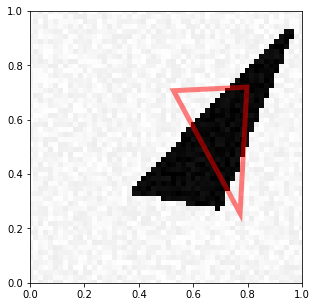

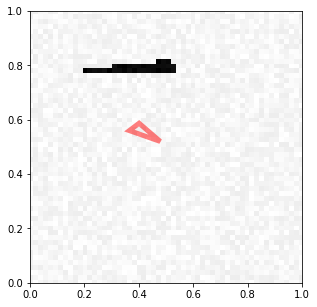

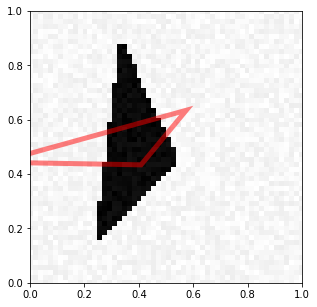

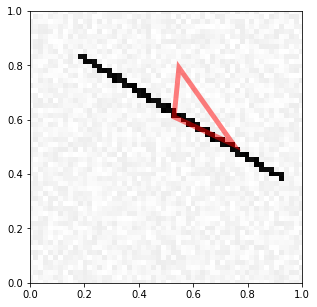

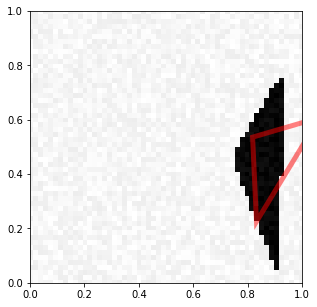

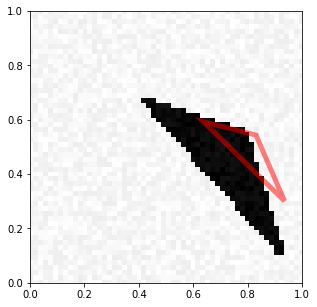

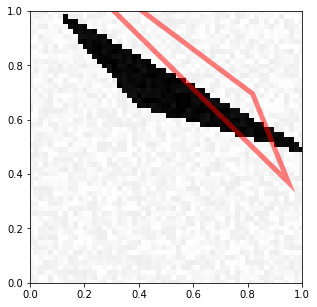

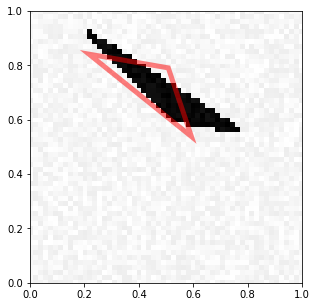

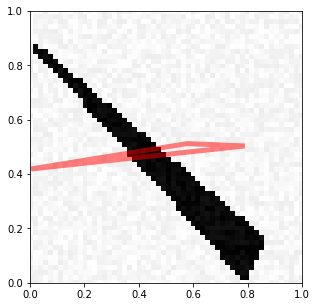

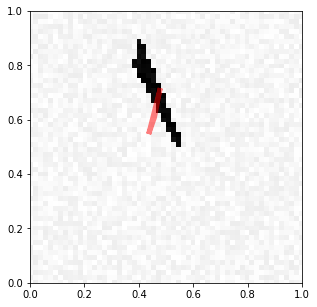

In [491]:
for i in range(0,10):
    visualize_prediction(X_test[i], predictions[i])

### Bonus Problem

We will attempt to utilize an hourglass network to be able to derid noisy images of their noise! Let's first change some of our helper functions so they return a noisy image of each image generated. 


<img src="http://www-personal.umich.edu/~alnewell/images/stacked-hg.png">



In [418]:
# import random 
import random

# some helper functions to make our life easier

def generate_a_rectangle(noise=0.0, free_location=False):
    #generate a random noise between 0,500
    noise_input = random.randint(0,500)
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    # change output so it returns two versions of the same image, one with noise and one without
    return generate_a_drawing(figsize, U, V, noise_input), generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    #generate a random noise between 0,500
    noise_input = random.randint(0,500)
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
     # change output so it returns two versions of the same image, one with noise and one without
    return generate_a_drawing(figsize, U, V, noise_input), generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    #generate a random noise between 0,500
    noise_input = random.randint(0,500)
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    # change output so it returns two versions of the same image, one with noise and one without
    imdata, imdata1 = generate_a_drawing(figsize, U, V, noise_input), generate_a_drawing(figsize, U, V, noise)
    return imdata, imdata1

def generate_dataset_hourglass(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = 5184
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            # at each iteration, returns noisy and noise-free rectangle 
            X[i], Y[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            # at each iteration, returns noisy and noise-free disk
            X[i], Y[i] = generate_a_disk(noise, free_location)
        else:
            # at each iteration, returns noisy and noise-free triangle
            X[i],Y[i] = generate_a_triangle(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_hourglass(nb_samples):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_hourglass(nb_samples, 20, True)
    return [X_test, Y_test]

Before we start with the hourglass network, let's make sure our code worked!

In [339]:
%%capture
# generate a new dataset
X_train, Y_train = generate_dataset_hourglass(1000, True)

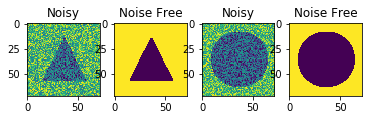

In [344]:
# compare two random samples
plt.figure()
plt.subplot(141)
plt.title("Noisy")
plt.imshow(X_train[6].reshape(72,72))
plt.subplot(142)
plt.imshow(Y_train[6].reshape(72,72))
plt.title("Noise Free")
# compare two random samples
plt.subplot(143)
plt.title("Noisy")
plt.imshow(X_train[100].reshape(72,72))
plt.subplot(144)
plt.title("Noise Free")
plt.imshow(Y_train[100].reshape(72,72))

In [345]:
# now let's reshape our data
X_train = X_train.reshape(1000,72,72,1)
Y_train = Y_train.reshape(1000,72,72,1)

### Hourglass Network

In [458]:
# create an hour glass model
hourglass_model = Sequential()
# add first conv block layer
hourglass_model.add(Conv2D(256, (5,5), input_shape = (72,72,1)))
hourglass_model.add(BatchNormalization())
hourglass_model.add(Activation('relu'))
hourglass_model.add(MaxPooling2D((2,2)))
# add second conv block
hourglass_model.add(Conv2D(64, (5,5)))
hourglass_model.add(BatchNormalization())
hourglass_model.add(Activation('relu'))
hourglass_model.add(MaxPooling2D((2,2)))
# add third conv block
hourglass_model.add(Conv2D(16, (5,5)))
hourglass_model.add(BatchNormalization())
hourglass_model.add(Activation('relu'))
# add 4th conv block
hourglass_model.add(UpSampling2D(size=(2, 2)))
hourglass_model.add(Conv2D(16, (5,5)))
hourglass_model.add(BatchNormalization())
hourglass_model.add(Activation('relu'))
# add 5th conv block
hourglass_model.add(UpSampling2D(size=(2, 2)))
hourglass_model.add(Conv2D(64, (1,1)))
hourglass_model.add(BatchNormalization())
hourglass_model.add(Activation('relu'))
# add 6th conv block
hourglass_model.add(UpSampling2D(size=(2, 2)))
hourglass_model.add(Conv2D(1, (1,1)))
hourglass_model.add(BatchNormalization())
hourglass_model.add(Activation('sigmoid'))

In [459]:
# print summary
hourglass_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_234 (Conv2D)          (None, 68, 68, 256)       6656      
_________________________________________________________________
batch_normalization_120 (Bat (None, 68, 68, 256)       1024      
_________________________________________________________________
activation_134 (Activation)  (None, 68, 68, 256)       0         
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 34, 34, 256)       0         
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 30, 30, 64)        409664    
_________________________________________________________________
batch_normalization_121 (Bat (None, 30, 30, 64)        256       
_________________________________________________________________
activation_135 (Activation)  (None, 30, 30, 64)        0         
__________

In [460]:
# run model 
hourglass_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy')
hourglass_model.fit(X_train, Y_train, validation_split = 0.3, epochs = 100, batch_size = 128)

Train on 700 samples, validate on 300 samples
Epoch 1/100
700/700 [==============================] - 129s 185ms/step - loss: -48.8334 - val_loss: 97.9507
Epoch 2/100
700/700 [==============================] - 126s 180ms/step - loss: -77.0171 - val_loss: -112.3460
Epoch 3/100
700/700 [==============================] - 125s 179ms/step - loss: -81.8740 - val_loss: -63.2503
Epoch 4/100
700/700 [==============================] - 126s 179ms/step - loss: -85.8094 - val_loss: -116.1338
Epoch 5/100
700/700 [==============================] - 126s 180ms/step - loss: -89.2616 - val_loss: -196.3383
Epoch 6/100
700/700 [==============================] - 126s 179ms/step - loss: -92.2739 - val_loss: -164.0436
Epoch 7/100
700/700 [==============================] - 126s 180ms/step - loss: -95.1697 - val_loss: -127.3308
Epoch 8/100
700/700 [==============================] - 126s 180ms/step - loss: -98.2822 - val_loss: -114.3124
Epoch 9/100
700/700 [==============================] - 127s 181ms/step - loss

In [419]:
# generate test set
%%capture
X_test, Y_test = generate_test_set_hourglass(100)

In [461]:
# reshape test set and predict
X_test = X_test.reshape(100,72,72,1)
predictions = hourglass_model.predict(X_test)

In [475]:
# reshape predictions
predictions = predictions.reshape(100,5184)
X_test = X_test.reshape(100,5184)

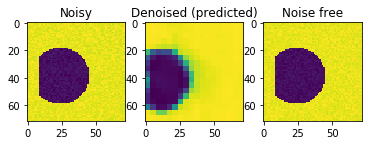

In [482]:
# compare one random sample
plt.subplot(131)
plt.title("Noisy")
plt.imshow(X_test[15].reshape(72,72))
plt.subplot(132)
plt.title("Denoised (predicted)")
plt.imshow(predictions[15].reshape(72,72))
plt.subplot(133)
plt.title("Noise free")
plt.imshow(Y_test[15].reshape(72,72))

Upon closer inspection with other random samples, it seems that our algorithm still needs some work! Maybe with either more training epochs, or by adding (or substracting) layers. 